# Spatial Autocorrelation

<img src="images/sa.png" width=600>

Visual interpretations are meaningful ways to determine spatial trends in our data. However, underlying factors—such as inconsistent geographies, scale, data gaps, overlapping data—has the potential to produce incorrect assumptions, as valuable information may be conveniently hidden from the visual output.

One way to address this issue is to amend your visual output with geo-statistical validation. In this lab, we will look at one such approach: Spatial Autocorrelation. Spatial autocorrelation addresses the so-called "First Law of Geography":

> “Everything is related to everything else. But near things are more related than distant things”. Waldo Tobler’s (1969) First Law of Geography

In other words, things that happen somewhere are likely to also happen at nearby locations.

In this lab, we take on the controversial topic of policing in Los Angeles, specifically looking at arrest records from the LAPD. Do arrest locations have a statistical significant tendency to cluster in certain communities? To answer this question, we not only look at the location of recorded arrests in the city, but compare these locations with other arrests. In short, we are seeking to see where spatial correlations occur based on the data. Our approach is:

1. import census block group boundaries for Los Angeles
1. import arrest data from the LA Open Data Portal
1. spatially join the two datasets
1. create a census block group geodataframe with a column for number of arrests
1. conduct [global spatial autocorrelation](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html) using Moran's I
1. conduct [local spatial autocorrelation](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html) using Local Indicators of Spatial Association (LISAs)

In [ ]:
!pip install sodapy==2.1.0

In [2]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt

## Block Groups

Our first task is to bring in a geography that will allow us to summarize the location of arrests. The smaller the geography, the better our spatial correlation results will be. Short of creating our own grid, the census block groups provides an easily accessible boundary layer at a human scale. Additionally, working at a census scale allows for future analysis that may include census data.

* https://geohub.lacity.org/datasets/9c040508fab24953b74921356fd94b1d_2

In [3]:
# get census tract boundaries from the LA City's GeoHub
gdf = gpd.read_file('https://opendata.arcgis.com/datasets/9c040508fab24953b74921356fd94b1d_2.geojson')

In [4]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6423 entries, 0 to 6422
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       6423 non-null   int64   
 1   GEOID10        6423 non-null   object  
 2   CTBG10         6423 non-null   object  
 3   CT10           6423 non-null   object  
 4   AreaSqMil      6423 non-null   float64 
 5   LABEL          6423 non-null   object  
 6   FIP10          6308 non-null   object  
 7   FIP10RV        6423 non-null   object  
 8   CDP_NAME       6308 non-null   object  
 9   CITYNAME       6423 non-null   object  
 10  COMMNAME       6423 non-null   object  
 11  ShapeSTArea    6423 non-null   float64 
 12  ShapeSTLength  6423 non-null   float64 
 13  geometry       6423 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(9)
memory usage: 702.6+ KB


In [5]:
# trim the data to the bare minimum columns
gdf = gdf[['GEOID10','geometry']]

# rename the columns
gdf.columns = ['FIPS','geometry']
gdf.head()

,FIPS,geometry
0,060372932023,"POLYGON ((-118.29910 33.81975, -118.29918 33.8..."
1,060372941201,"POLYGON ((-118.24598 33.80005, -118.24600 33.8..."
2,060372932022,"POLYGON ((-118.29908 33.82230, -118.29930 33.8..."
3,060372932021,"POLYGON ((-118.29920 33.82570, -118.29939 33.8..."
4,060372941101,"POLYGON ((-118.25846 33.79945, -118.25754 33.8..."


In [6]:
# get the layers into a web mercator projection
# reproject to web mercator
gdf = gdf.to_crs(epsg=3857)

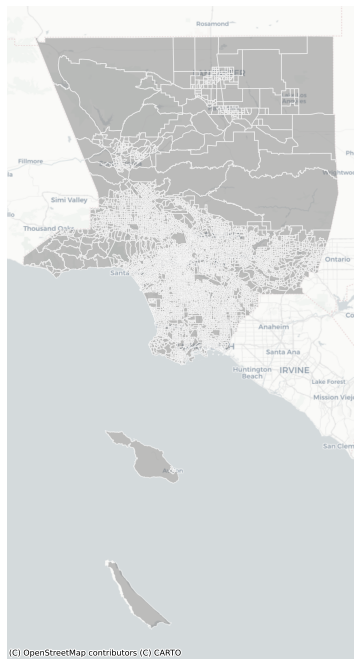

In [7]:
# plot it!
ax=gdf.plot(figsize=(12,12),
                      color='gray', 
                      edgecolor='white',
                      alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Get Arrest Data from LA Open Data Portal
Next, we acquire the data using the socrata API. Use the socrata documentation to grab the code syntax for our arrests data.
- https://dev.socrata.com/foundry/data.lacity.org/amvf-fr72

In [8]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2020-03-01T00:00:00' and '2020-10-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)


In [9]:
arrests.shape

(36216, 25)

### Convert data to a geodataframe

Geopandas allows us to convert different types of data into a spatial format.
- https://geopandas.org/gallery/create_geopandas_from_pandas.html

In [10]:
# convert pandas dataframe to geodataframe
arrests = gpd.GeoDataFrame(arrests, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [11]:
# get the layers into a web mercator projection
# reproject to web mercator
arrests = arrests.to_crs(epsg=3857)

In [12]:
# convert lat/lon to floats
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

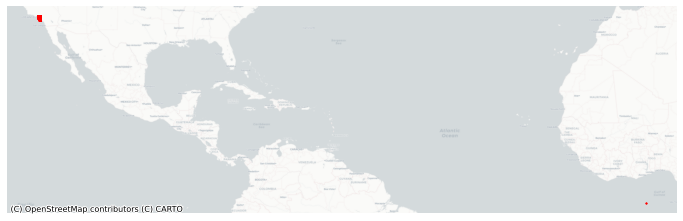

In [13]:
# map it!
ax = arrests.plot(figsize=(12,12),
                  color='red',
                  markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


### The 0,0 conundrum
What is that red dot off the coast of Africa? Yes, that is the infamous spatial black hole, the [0,0] coordinate. There can be many reasons why a record assumes these coordinates. No coordinates may default to 0's, null values may be converted to 0's, or a human may have entered 0's for unknown locations. Either which way, since these records do not have valid locations, they need to be deleted from our dataframe in order to proceed.

In [14]:
# subset the zero coordinate records
arrests[arrests.lon==0]

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry
18173,5951250,BOOKING,2020-06-09T00:00:00.000,0025,06,Hollywood,0665,39,M,O,...,FOUNTAIN,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2020-06-09T00:00:00.000,0224,HOLLYWOOD,4206,MACCADEN,POINT (0.00000 0.00000)
26039,5921308,BOOKING,2020-04-26T00:00:00.000,1500,19,Mission,1942,25,M,H,...,REGAN FY,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2020-04-26T00:00:00.000,1631,VALLEY - JAIL DIV,4279,LAUREL CANYON BL,POINT (0.00000 0.00000)


In [15]:
# drop the unmapped rows
arrests.drop(arrests[arrests.lon==0].index,inplace=True)

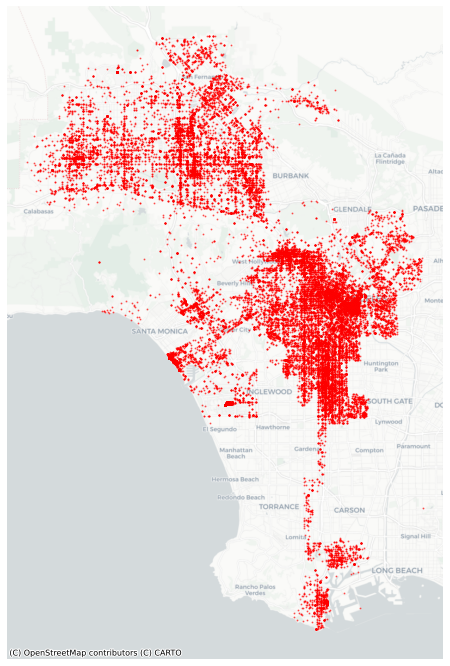

In [16]:
# map it again
ax = arrests.plot(figsize=(12,12),
                  color='red',
                  markersize=1,
                  alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Create a two layer map

- https://geopandas.org/mapping.html

Since we want to zoom to the extent of the arrests layer (and not the block groups), get the bounding coordinates for our axis.

In [17]:
# get the bounding box coordinates for the arrest data
minx, miny, maxx, maxy = arrests.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13209059.458039049
-13153388.580693332
3989526.8110836204
4072889.465652517


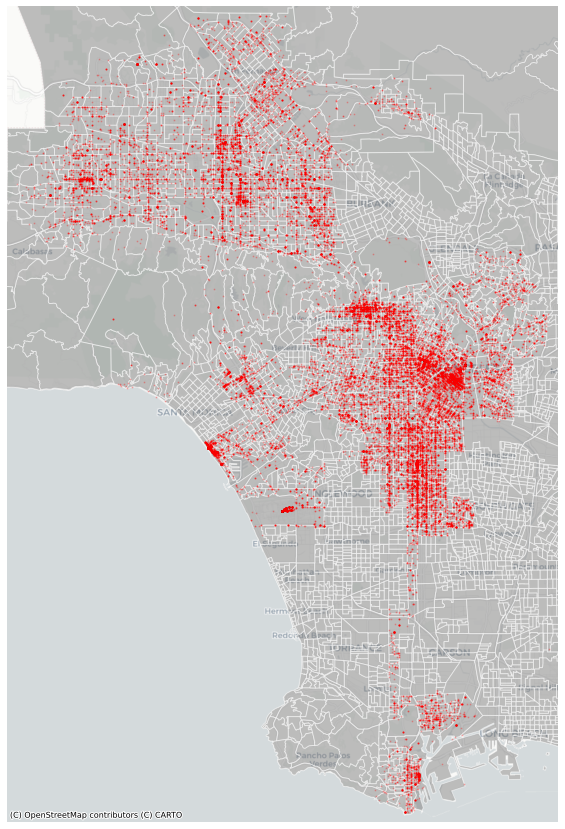

In [21]:
# set up the plot canvas
fig, ax = plt.subplots(figsize=(15, 15))

# block groups
gdf.plot(ax=ax,
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# arrests
arrests.plot(ax=ax, 
            color='red',
            markersize=1,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## The spatial join

* https://geopandas.org/mergingdata.html?highlight=spatial%20join

In a Spatial Join, two geometry objects are merged based on their spatial relationship to one another.

The how argument specifies the type of join that will occur and which geometry is retained in the resultant geodataframe. It accepts the following options:

`left`: use the index from the first (or left_df) geodataframe that you provide to sjoin; retain only the left_df geometry column

`right`: use index from second (or right_df); retain only the right_df geometry column

`inner`: use intersection of index values from both geodataframes; retain only the left_df geometry column



In [34]:
# Do the spatial join
join = gpd.sjoin(gdf,
                 arrests,
                 how='right')

This created a dataframe that has every arrest record with the corresponding FIPS code.

Next, we create another dataframe that counts crime by their corresponding block group:

In [35]:
arrests_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='arrests_count')

In [38]:
arrests_by_gdf.head()

,FIPS,arrests_count
0,060379800281,709
1,060372088011,310
2,060372077101,286
3,060372063003,245
4,060371907001,233


<AxesSubplot:xlabel='FIPS'>

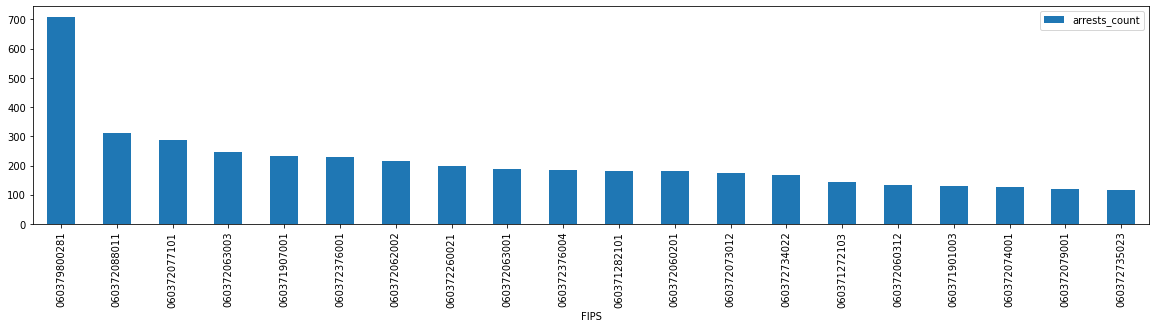

In [40]:
# make a bar chart of top 20 geographies
arrests_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='arrests_count')

## Join the value counts back to the gdf

The bar chart is nice, but what we want is a choropleth map to accompany it. To do so, we merge the counts back to the block group gdf.

In [41]:
# join the summary table back to the gdf
gdf=gdf.merge(arrests_by_gdf,on='FIPS')

Now the block group gdf has a new column for arrest counts:

In [42]:
# our neighborhood table now has a count column
gdf.head()

,FIPS,geometry,arrests_count
0,060372932023,"POLYGON ((-13168995.036 4004624.033, -13169004...",13
1,060372941201,"POLYGON ((-13163082.634 4001985.500, -13163084...",4
2,060372932022,"POLYGON ((-13168993.812 4004966.790, -13169017...",3
3,060372932021,"POLYGON ((-13169006.391 4005421.849, -13169028...",2
4,060372941101,"POLYGON ((-13164471.234 4001904.320, -13164369...",2


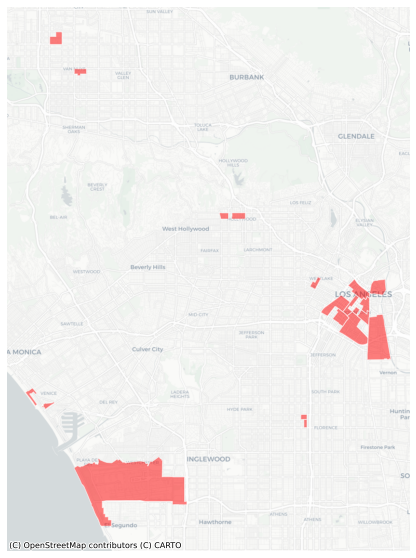

In [49]:
# map the top 20 geographies
ax = gdf.sort_values(by='arrests_count',ascending=False)[:20].plot(figsize=(12,10),
                                                             color='red',
                                                             edgecolor='white',
                                                             alpha=0.5,legend=True)



# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Choropleth map of arrests

Finally, we are ready to generate a choropleth map of arrests. First, let's get some simply stats of the `arrests_count` column.

<AxesSubplot:>

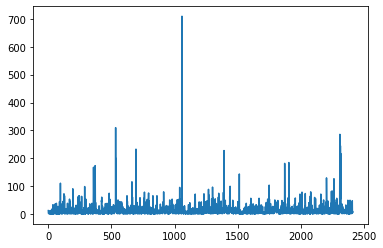

In [50]:
gdf.arrests_count.plot()

Notice the outlier. Any guesses on where that is?

In [51]:
gdf.arrests_count.describe()

count    2410.000000
mean       15.025311
std        26.001752
min         1.000000
25%         4.000000
50%         8.000000
75%        17.000000
max       709.000000
Name: arrests_count, dtype: float64

What do the above statistics tell you?

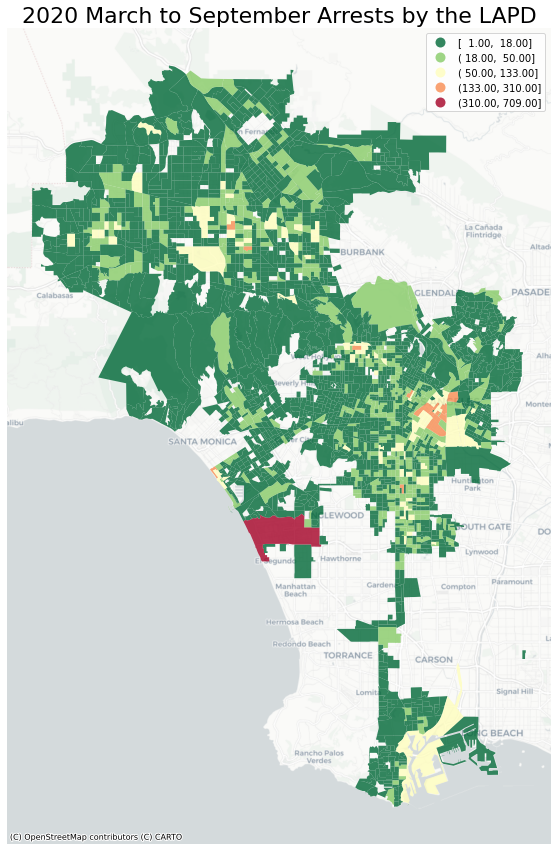

In [52]:
ax = gdf.plot(figsize=(15,15),
                        column='arrests_count',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r',
                        scheme='naturalbreaks')

ax.axis('off')
ax.set_title('2020 March to September Arrests by the LAPD',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The map above is a good way to begin exploring spatial patterns in our data. What does this map tell you? Is it informative? Do you notice any significant clusters? What if you change the map? Notice the `scheme` argument is set to `naturalbreaks`. Experiment with other map classfications such as `equalinterval`, `quantiles`. How does each classification change the map? 

# Spatial Autocorrelation

## Spatial Weights
Spatial weights are how we determine the area’s neighborhood. There are different statistical methods that are used for determining spatial weights. Some use a contiguity model, assigning neighbors based on boundaries that touch each other. Others are based on distance, finding the closest neighbors based on the centroid of each geography. Given that the City of Los Angeles has an unusual shape, the distance weight is more adequate than the contiguity approach.

For this lab, we will use the KNN weight, where `k` is the number of "nearest neighbors" to count in the calculations. Let's proceed with `k=8` for our KNN spatial weights.

- https://geographicdata.science/book/notebooks/04_spatial_weights.html#distance-based-weights


In [54]:
# calculate spatial weight
wq =  lps.weights.KNN.from_dataframe(gdf,k=8)
wq.transform = 'r'

## Spatial lag

Now that we have our spatial weights assigned, we use it to calculate the spatial lag. While the mathematical operations are beyond the scope of this lab, you are welcome to check it out [here](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html#spatial-lag). Simply put, the spatial lag is a calculated assignment to each geography in your data, which takes into account the data values from others in their  "neighborhood" as defined by the spatial weight. This operation can be done with a single line of code which is part of the pysal module.

In [55]:
# create a new column for the spatial lag
gdf['arrests_count_lag'] = lps.weights.lag_spatial(wq, gdf['arrests_count'])

In [56]:
gdf.sort_values(by='arrests_count',ascending=False).head()

,FIPS,geometry,arrests_count,arrests_count_lag
1058,060379800281,"POLYGON ((-13178640.094 4022802.672, -13178707...",709,6.000
533,060372088011,"POLYGON ((-13166054.534 4037260.611, -13166082...",310,33.375
2308,060372077101,"POLYGON ((-13163728.847 4035353.985, -13163847...",286,58.500
2312,060372063003,"POLYGON ((-13162972.653 4034790.390, -13163045...",245,109.750
694,060371907001,"POLYGON ((-13172064.340 4041968.481, -13172065...",233,41.500


In order to better understand the significance of the spatial lag values, consider the following two geographies:

In [58]:
gdf[gdf['FIPS'].isin(['060379800281', '060372062001'])]

,FIPS,geometry,arrests_count,arrests_count_lag
1058,060379800281,"POLYGON ((-13178640.094 4022802.672, -13178707...",709,6.000
2316,060372062001,"POLYGON ((-13162850.424 4034739.204, -13162801...",92,128.875


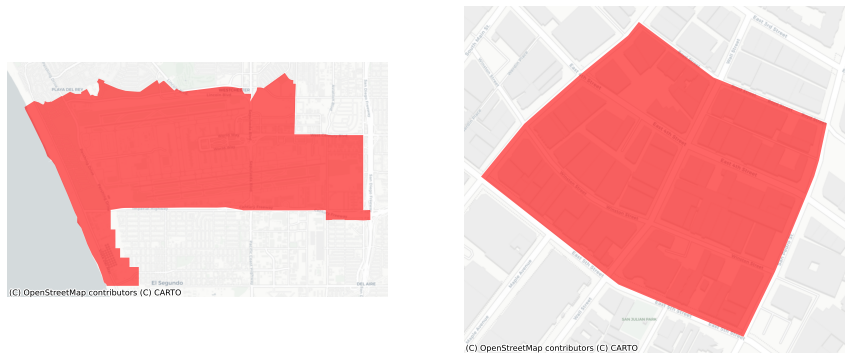

In [64]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# name each subplot
ax1, ax2 = axs

gdf[gdf['FIPS'].isin(['060379800281'])].plot(ax = ax1,
                                            color='red',
                                            alpha=0.6)

gdf[gdf['FIPS'].isin(['060372062001'])].plot(ax = ax2,
                                            color='red',
                                            alpha=0.6)

ax1.axis('off')
ax2.axis('off')
ctx.add_basemap(ax1,source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2,source=ctx.providers.CartoDB.Positron)

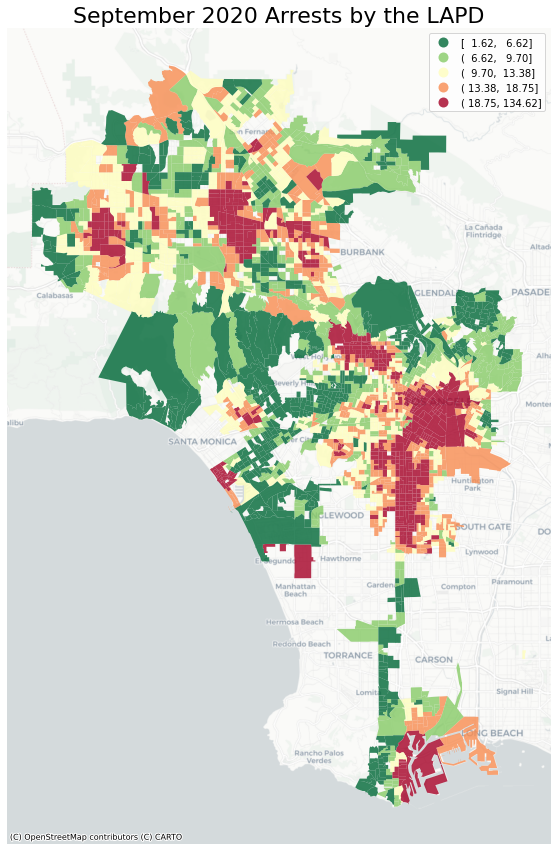

In [65]:
ax = gdf.plot(figsize=(15,15),
                        column='arrests_count_lag',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r',scheme='quantiles')

ax.axis('off')
ax.set_title('September 2020 Arrests by the LAPD',fontsize=22)
# ax = arrests.plot(ax=ax, color='blue',markersize =1,alpha=0.2, legend=True)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

We can now compare these two map outputs side by side. Notice that the syntax is a bit different from past labs where we have only worked with one figure at a time. This output produces 1 row, and 2 columns of figures called `subplots`.

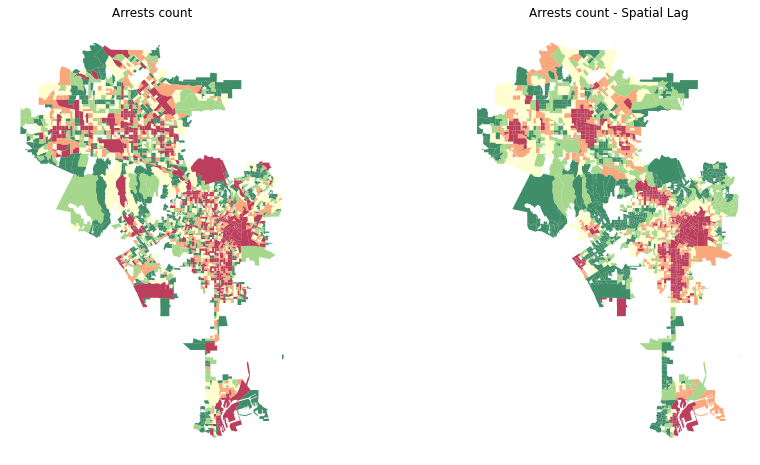

In [66]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
gdf.plot(column='arrests_count', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
#             legend=True, 
            ax=ax1 # this assigns the map to the subplot
           )


ax1.axis("off")
ax1.set_title("Arrests count")

# spatial lag map on the right
gdf.plot(column='arrests_count_lag', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
#             legend=True, 
            ax=ax2 # this assigns the map to the subplot
           )

ax2.axis("off")
ax2.set_title("Arrests count - Spatial Lag")

plt.show()

## Moran's I

In [67]:
y = gdf.arrests_count
moran = Moran(y, wq)
moran.I

0.22100924434272579

The other bit of information we will extract from Moran’s I relates to statistical inference: how likely is the pattern we observe in the map and Moran’s I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, PySAL performs a simulation and returns a measure of certainty about how likely it is the pattern we observe in our dataset came from a spatially random process. This is summarised in the p_sim attribute:

In [ ]:
moran.p_sim

The value is calculated as an empirical P-value that represents the proportion of realisations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in PySAL) and, by standard terms, it would be deemed statistically significant. We can ellaborate a bit further on the intuition behind the value of p_sim. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran’s I. If we remember again that the value of Moran’s I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the vote proportions among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the EU Referendum vote was highly marked: nearby areas tended to vote alike.

Thanks to the splot visualisation module in PySAL, we can obtain a quick representation of the statistic that combines the Moran Plot (right) with a graphic of the empirical test that we carry out to obtain p_sim (left):

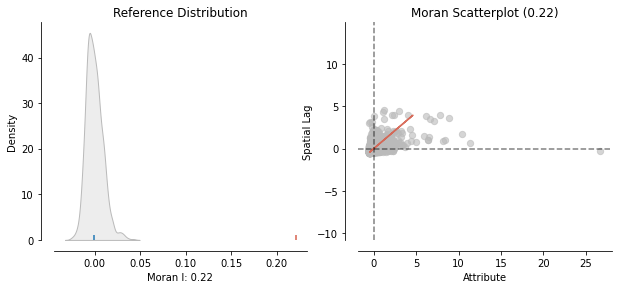

In [68]:
plot_moran(moran);

In [69]:
lisa = esda.moran.Moran_Local(y, wq)

- https://pysal.org/esda/generated/esda.Moran_Local.html

In [70]:
# how many per quadrant?
counts = [(j,(lisa.q==j).sum()) for j in range(1,5)]
counts

[(1, 400), (2, 355), (3, 1347), (4, 308)]

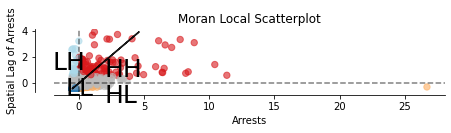

In [71]:
# Plot
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel("Arrests")
ax.set_ylabel('Spatial Lag of Arrests')
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

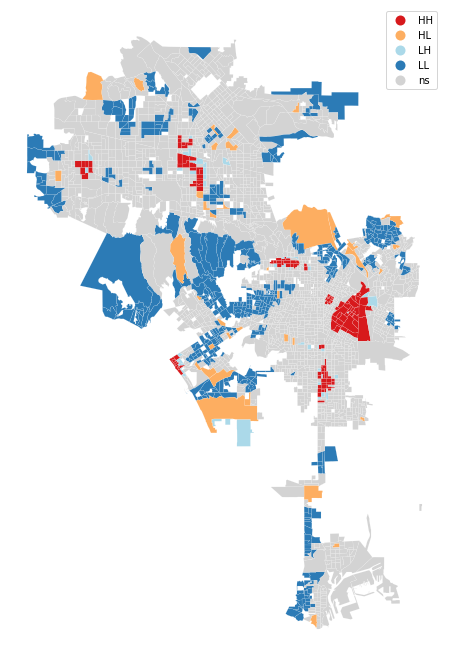

In [72]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, gdf, p=0.05, figsize = (16,12),ax=ax)
plt.show()

## Identifying significant rows

The correspondence between the numbers in the q attribute and the actual quadrants is as follows:

1: HH

2: LH

3: LL

4: HL

In [ ]:
# original df... how many rows?
len(gdf)

In [ ]:
# original value list
lisa.y[:5]

In [ ]:
# quadrant list
lisa.q[:5]

In [ ]:
# p sim list
lisa.p_sim[:5]

In [ ]:
# add it to the dataframe
gdf['q'] = lisa.q.tolist()

In [ ]:
# add it to the dataframe
gdf['p_sim'] = lisa.p_sim.tolist()

In [ ]:
gdf[gdf.p_sim < 0.05].plot(figsize=(12,12),column='q',legend=True,categorical=True,cmap='RdYlBu')

# Resources

- https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html
- https://pysal.org/esda/notebooks/spatialautocorrelation.html
- https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee

In [ ]:
gdf

In [ ]:
gdf

In [ ]:
gdf

In [ ]:
gdf

In [ ]:
gdf

In [ ]:
gdf

In [ ]:
results

In [ ]:
arrests

In [ ]:
ax

In [ ]:
client